In [75]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [76]:
qvi = pd.read_csv('/content/drive/MyDrive/Quantium Data Analytics/QVI_data.csv')
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [77]:
qvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


# Select Control Stores:

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :

*   Monthly overall sales revenue
*   Monthly number of customers
*   Monthly number of transactions per customer





In [78]:
# Lets Creat the store Matrix:
# Format 'DATE' columns
qvi["DATE"] = pd.to_datetime(qvi["DATE"], format="%Y-%m-%d")

# Add a new 'MONTH_ID' column in the data with the format yyyymm
qvi["MONTH_ID"] = qvi["DATE"].dt.strftime("%Y%m").astype("int")
qvi["MONTH_ID"].head()

0    201810
1    201809
2    201903
3    201903
4    201811
Name: MONTH_ID, dtype: int64

Defining the measures to use during Analysis:

In [79]:
# Monthly total sales
M_TOT_SALES = qvi.groupby(["STORE_NBR","MONTH_ID"])["TOT_SALES"].sum()

# Monthly customer counts
M_CUS_COUNTS = qvi.groupby(["STORE_NBR","MONTH_ID"])["LYLTY_CARD_NBR"].nunique()

# Monthly transactions per customer
M_TXN_CUS = qvi.groupby(["STORE_NBR","MONTH_ID"])["TXN_ID"].nunique()/M_CUS_COUNTS

# Monthly chips per customer
M_CHIP_CUS = qvi.groupby(["STORE_NBR","MONTH_ID"])["PROD_QTY"].sum()/M_CUS_COUNTS

# Monthly average price per unit
M_AVG_PRICE_CHIP = M_TOT_SALES/qvi.groupby(["STORE_NBR","MONTH_ID"])["PROD_QTY"].sum()

# Combining metrics together
measureOverTime = pd.concat([M_TOT_SALES, M_CUS_COUNTS, M_TXN_CUS, M_CHIP_CUS, M_AVG_PRICE_CHIP],axis=1)                                 
measureOverTime.columns = ["totSales", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
measureOverTime = measureOverTime.reset_index()
measureOverTime

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,2.022222,4.346154
3165,272,201903,442.3,50,1.060000,2.020000,4.379208
3166,272,201904,445.1,54,1.018519,1.944444,4.239048
3167,272,201905,314.6,34,1.176471,2.088235,4.430986


Dividing the full observation period:

In [80]:
# Stores with full observation periods(12 month)
obs_counts = measureOverTime["STORE_NBR"].value_counts()
full_idx = obs_counts[obs_counts == 12].index
storesWithFullObs = measureOverTime[measureOverTime["STORE_NBR"].isin(full_idx)]

# Filter to the pre-trial period (201807 - 201901)
preTrialMeasures = storesWithFullObs[storesWithFullObs["MONTH_ID"] < 201902]
preTrialMeasures.head(8)

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
5,1,201812,189.6,42,1.119048,1.357143,3.326316
6,1,201901,154.8,35,1.028571,1.200000,3.685714
12,2,201807,150.8,39,1.051282,1.179487,3.278261


Creating Functions for Calculation:

In [81]:
def calculateCorrelation(inputTable, metricCol, storeComparison):
    
    """'inputTable'      as a metric table with potential comparison stores 
       'metricCol'       as the store metric used to calculate correlation on 
       'storeComparison' as the store number of the trial store."""
    
    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])]
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    calcCorrTable = pd.DataFrame(columns = ["Control_Store", "Trial_Store", "Corr"])
    
    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i][metricCol].reset_index()              
        correlation = control.corrwith(trial,axis=0)[1]
        calcCorrTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":storeComparison,"Corr":[correlation]}) 
        calcCorrTable = pd.concat([calcCorrTable, calcCorrTable_i])
     
    return calcCorrTable


In [82]:
# Create a function to calculate a standardised magnitude distance for a measure, looping through each control store

def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):
    
    """'inputTable'      as a metric table with potential comparison stores 
       'metricCol'       as the store metric used to calculate correlation on 
       'storeComparison' as the store number of the trial store."""
    
    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])]
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol]
    calcDistTable = pd.DataFrame(columns=["Control_Store", "Trial_Store", "Magnitude"])
    
    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i].reset_index()[metricCol]
        diff = abs(trial - control)
        # Standardise the magnitude distance so that the measure ranges from 0 to 1
        s_diff = np.mean(1-((diff-min(diff))/(max(diff)-min(diff))))
        calcDistTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":[storeComparison],"Magnitude": s_diff})
        calcDistTable = pd.concat([calcDistTable, calcDistTable_i])
    return calcDistTable

#calculateMagnitudeDistance(preTrialMeasures,"totSales",77)               

Select Control Stores:

Store 77

In [83]:
# calculate correlations against store 77 using total sales and number of customers
# total sales - corr
corr_nSales_77 = calculateCorrelation(preTrialMeasures,"totSales",77)

# total sales - magnitude distance
magnitude_nSales_77 = calculateMagnitudeDistance(preTrialMeasures,"totSales",77) 

# number of customers - corr
corr_nCustomers_77 = calculateCorrelation(preTrialMeasures,"nCustomers",77)

# number of customers - magnitude distance
magnitude_nCustomers_77 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",77) 

In [84]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_77_merge = pd.concat([corr_nSales_77,magnitude_nSales_77["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_77_merge["score_nSales"] = corr_weight_a * nSales_77_merge["Corr"] + (1-corr_weight_a) * nSales_77_merge["Magnitude"]
nSales_77_merge

,Control_Store,Trial_Store,Corr,Magnitude,score_nSales
0,1,77,0.075218,0.408163,0.241691
0,2,77,-0.263079,0.590119,0.163520
0,3,77,0.806644,0.522914,0.664779
0,4,77,-0.263300,0.644934,0.190817
0,5,77,-0.110652,0.516320,0.202834
...,...,...,...,...,...
0,268,77,0.344757,0.429787,0.387272
0,269,77,-0.315730,0.559099,0.121684
0,270,77,0.315430,0.591547,0.453489
0,271,77,0.355487,0.341091,0.348289


In [85]:
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_77_merge = pd.concat([corr_nCustomers_77,magnitude_nCustomers_77["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_77_merge["score_nCustomers"] = corr_weight_b * nCustomers_77_merge["Corr"] + (1-corr_weight_b) * nCustomers_77_merge["Magnitude"]
nCustomers_77_merge

,Control_Store,Trial_Store,Corr,Magnitude,score_nCustomers
0,1,77,0.322168,0.663866,0.493017
0,2,77,-0.572051,0.471429,-0.050311
0,3,77,0.834207,0.489796,0.662002
0,4,77,-0.295639,0.498258,0.101310
0,5,77,0.370659,0.512605,0.441632
...,...,...,...,...,...
0,268,77,0.369517,0.571429,0.470473
0,269,77,-0.474293,0.484472,0.005090
0,270,77,-0.131259,0.536680,0.202710
0,271,77,0.019629,0.328571,0.174100


In [86]:
# Merging the score tables
finalControlScore_77 = pd.concat([nSales_77_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_77_merge["score_nCustomers"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_77["finalControlScore"] = corr_weight_c * finalControlScore_77["score_nSales"] + (1-corr_weight_c) * finalControlScore_77["score_nCustomers"]
finalControlScore_77

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,1,77,0.241691,0.493017,0.367354
0,2,77,0.163520,-0.050311,0.056604
0,3,77,0.664779,0.662002,0.663390
0,4,77,0.190817,0.101310,0.146064
0,5,77,0.202834,0.441632,0.322233
...,...,...,...,...,...
0,268,77,0.387272,0.470473,0.428872
0,269,77,0.121684,0.005090,0.063387
0,270,77,0.453489,0.202710,0.328100
0,271,77,0.348289,0.174100,0.261195


In [87]:
# Find out the control store with the highest final score
finalControlScore_77.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,233,77,0.697290,0.816607,0.756949
0,71,77,0.789497,0.663123,0.726310
0,84,77,0.656972,0.715000,0.685986
0,119,77,0.636046,0.729729,0.682887
0,115,77,0.708347,0.645155,0.676751


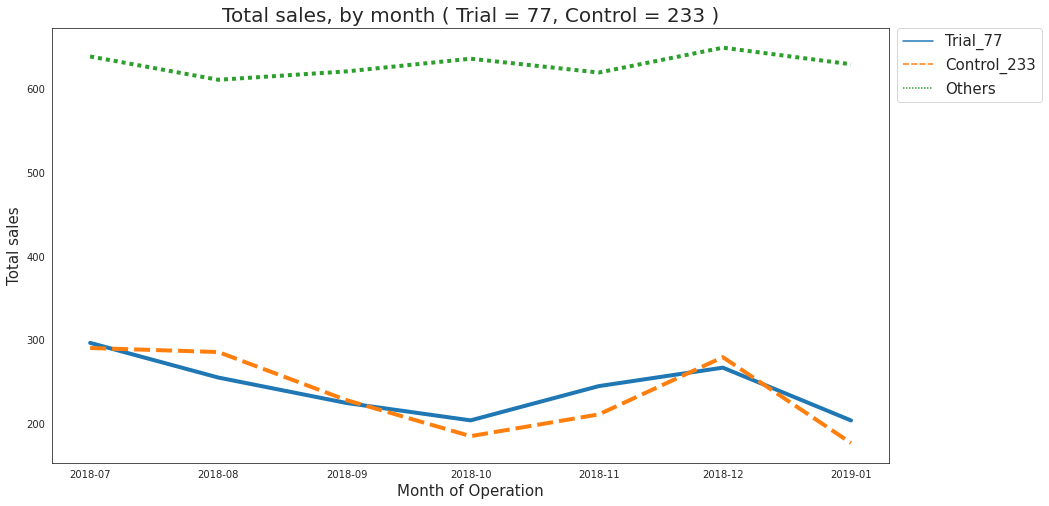

In [88]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [77, 233]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_77_s = a.loc[:,([77,233,"others"])].reset_index()
paired_77_s["MONTH_ID"]= pd.to_datetime(paired_77_s["MONTH_ID"], format="%Y%m")
paired_77_s = paired_77_s.set_index(["MONTH_ID"])
paired_77_s.columns=["Trial_77","Control_233","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

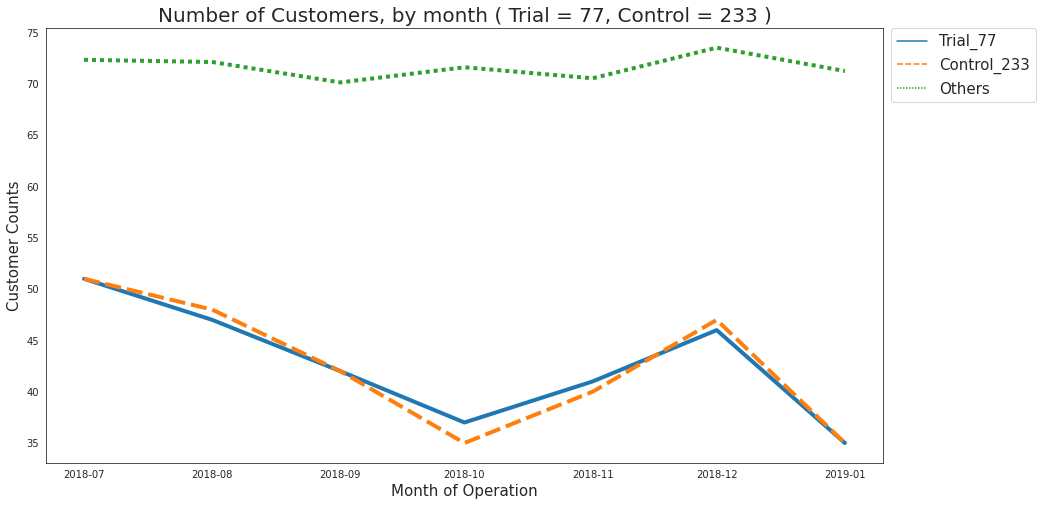

In [89]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [77, 233]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_77_c = b.loc[:,([77,233,"others"])].reset_index()
paired_77_c["MONTH_ID"]= pd.to_datetime(paired_77_c["MONTH_ID"], format="%Y%m")
paired_77_c = paired_77_c.set_index(["MONTH_ID"])
paired_77_c.columns=["Trial_77","Control_233","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

Store 86

In [90]:
# calculate correlations against store 86 using total sales and number of customers
# total sales - corr
corr_nSales_86 = calculateCorrelation(preTrialMeasures,"totSales",86)

# total sales - magnitude distance
magnitude_nSales_86 = calculateMagnitudeDistance(preTrialMeasures,"totSales",86) 

# number of customers - corr
corr_nCustomers_86 = calculateCorrelation(preTrialMeasures,"nCustomers",86)

# number of customers - magnitude distance
magnitude_nCustomers_86 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",86) 

In [91]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_86_merge = pd.concat([corr_nSales_86,magnitude_nSales_86["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_86_merge["score_nSales"] = corr_weight_a * nSales_86_merge["Corr"] + (1-corr_weight_a) * nSales_86_merge["Magnitude"]
#nSales_86_merge

In [92]:
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_86_merge = pd.concat([corr_nCustomers_86,magnitude_nCustomers_86["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_86_merge["score_nCustomers"] = corr_weight_b * nCustomers_86_merge["Corr"] + (1-corr_weight_b) * nCustomers_86_merge["Magnitude"]
#nCustomers_86_merge

In [93]:
# Merging the score tables
finalControlScore_86 = pd.concat([nSales_86_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_86_merge["score_nCustomers"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_86["finalControlScore"] = corr_weight_c * finalControlScore_86["score_nSales"] + (1-corr_weight_c) * finalControlScore_86["score_nCustomers"]
#finalControlScore_86

In [94]:
# Find out the control store with the highest final score
finalControlScore_86.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,155,86,0.808106,0.733343,0.770724
0,109,86,0.697120,0.742532,0.719826
0,114,86,0.631393,0.663384,0.647389
0,225,86,0.601841,0.684356,0.643099
0,138,86,0.593296,0.660565,0.626930


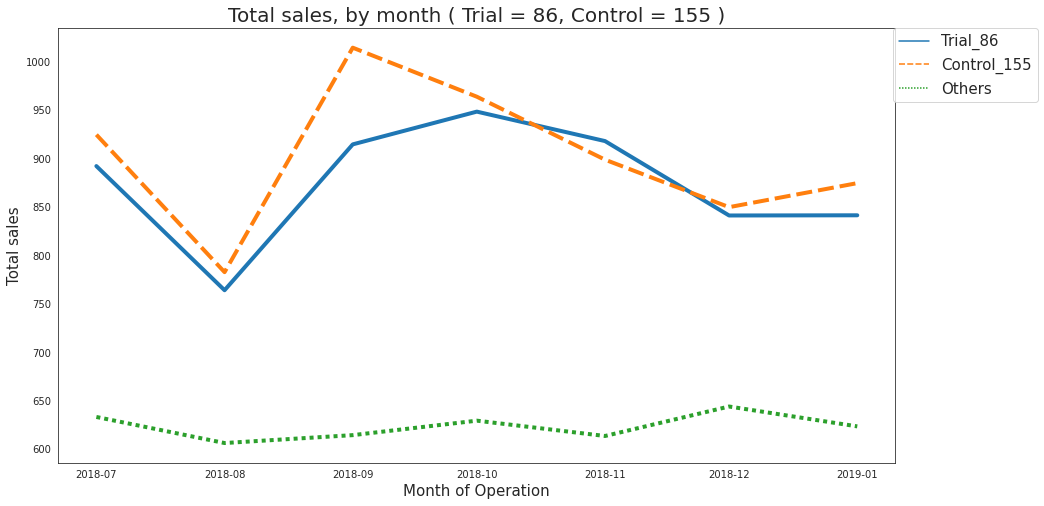

In [95]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [86, 155]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_86_s = a.loc[:,([86,155,"others"])].reset_index()
paired_86_s["MONTH_ID"]= pd.to_datetime(paired_86_s["MONTH_ID"], format="%Y%m")
paired_86_s = paired_86_s.set_index(["MONTH_ID"])
paired_86_s.columns=["Trial_86","Control_155","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 86, Control = 155 )",fontsize=20)
sns.lineplot(data=paired_86_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

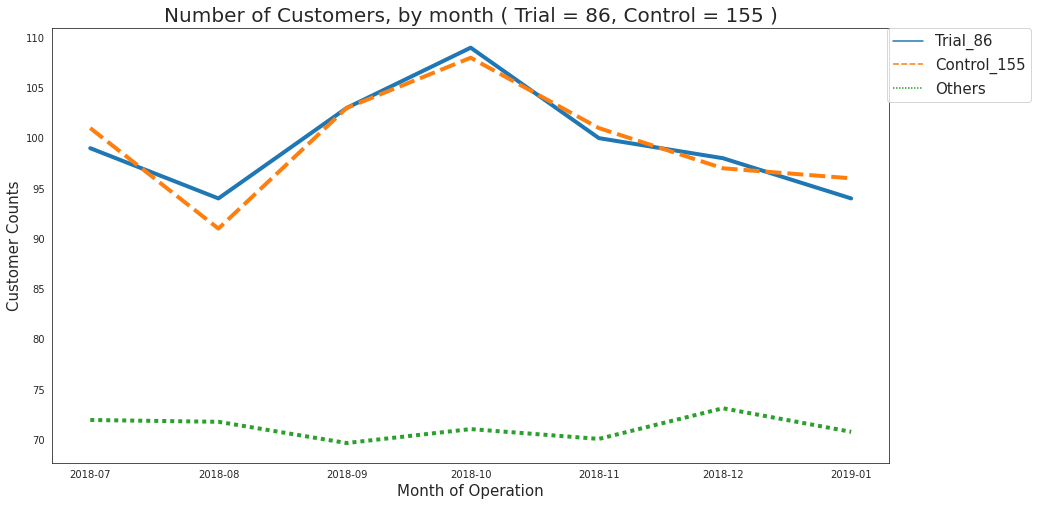

In [96]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [86, 155]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_86_c = b.loc[:,([86,155,"others"])].reset_index()
paired_86_c["MONTH_ID"]= pd.to_datetime(paired_86_c["MONTH_ID"], format="%Y%m")
paired_86_c = paired_86_c.set_index(["MONTH_ID"])
paired_86_c.columns=["Trial_86","Control_155","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 86, Control = 155 )",fontsize=20)
sns.lineplot(data=paired_86_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

Store 88:

In [97]:
# calculate correlations against store 88 using total sales and number of customers
# total sales - corr
corr_nSales_88 = calculateCorrelation(preTrialMeasures,"totSales",88)

# total sales - magnitude distance
magnitude_nSales_88 = calculateMagnitudeDistance(preTrialMeasures,"totSales",88) 

# number of customers - corr
corr_nCustomers_88 = calculateCorrelation(preTrialMeasures,"nCustomers",88)

# number of customers - magnitude distance
magnitude_nCustomers_88 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",88) 

In [98]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_88_merge = pd.concat([corr_nSales_88,magnitude_nSales_88["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_88_merge["score_nSales"] = corr_weight_a * nSales_88_merge["Corr"] + (1-corr_weight_a) * nSales_88_merge["Magnitude"]
#nSales_88_merge

In [99]:
# Merging the correlations table with the magnitude table - number of Customers
nCustomers_88_merge = pd.concat([corr_nCustomers_88,magnitude_nCustomers_88["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_88_merge["score_nCustomers"] = corr_weight_b * nCustomers_88_merge["Corr"] + (1-corr_weight_b) * nCustomers_88_merge["Magnitude"]
#nCustomers_88_merge

In [100]:
# Merging the score tables
finalControlScore_88 = pd.concat([nSales_88_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_88_merge["score_nCustomers"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_88["finalControlScore"] = corr_weight_c * finalControlScore_88["score_nSales"] + (1-corr_weight_c) * finalControlScore_88["score_nCustomers"]
#finalControlScore_88

In [101]:
# Find out the control store with the highest final score
finalControlScore_88.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,178,88,0.650803,0.707828,0.679316
0,14,88,0.646064,0.685774,0.665919
0,134,88,0.775084,0.540154,0.657619
0,237,88,0.451974,0.777235,0.614604
0,187,88,0.616752,0.594560,0.605656


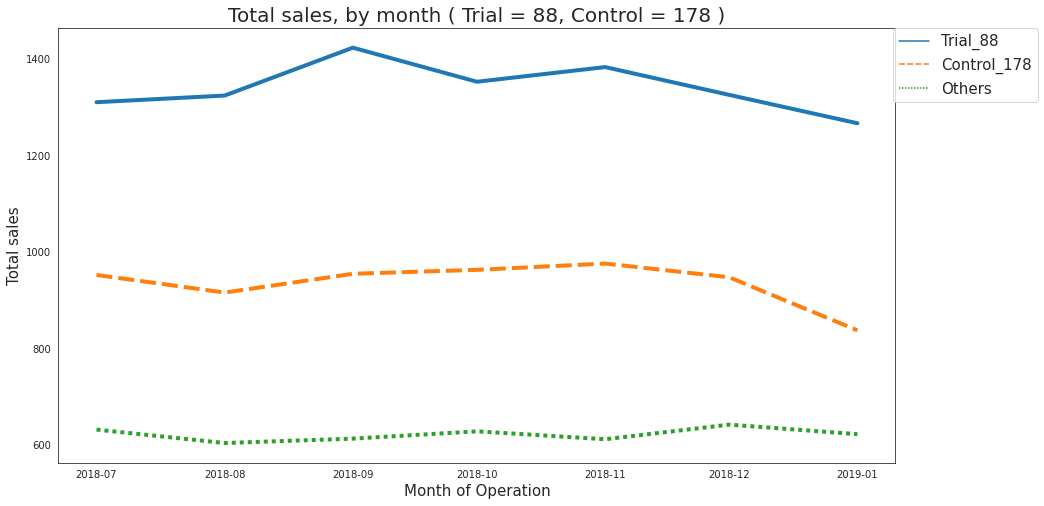

In [102]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [88, 178]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_88_s = a.loc[:,([88,178,"others"])].reset_index()
paired_88_s["MONTH_ID"]= pd.to_datetime(paired_88_s["MONTH_ID"], format="%Y%m")
paired_88_s = paired_88_s.set_index(["MONTH_ID"])
paired_88_s.columns=["Trial_88","Control_178","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 88, Control = 178 )",fontsize=20)
sns.lineplot(data=paired_88_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

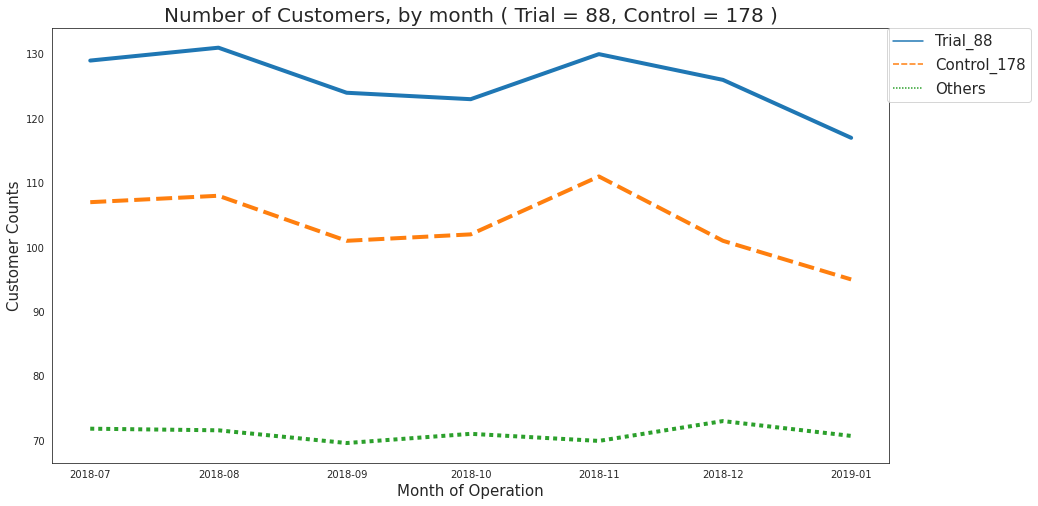

In [103]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 178]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,178,"others"])].reset_index()
paired_88_c["MONTH_ID"]= pd.to_datetime(paired_88_c["MONTH_ID"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["MONTH_ID"])
paired_88_c.columns=["Trial_88","Control_178","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 178 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

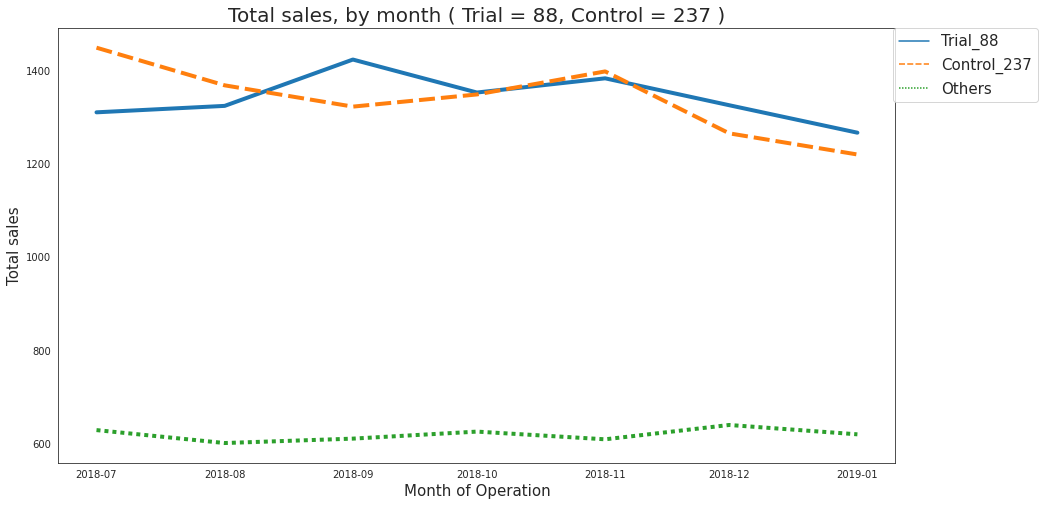

In [104]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [88, 237]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_88_s = a.loc[:,([88,237,"others"])].reset_index()
paired_88_s["MONTH_ID"]= pd.to_datetime(paired_88_s["MONTH_ID"], format="%Y%m")
paired_88_s = paired_88_s.set_index(["MONTH_ID"])
paired_88_s.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

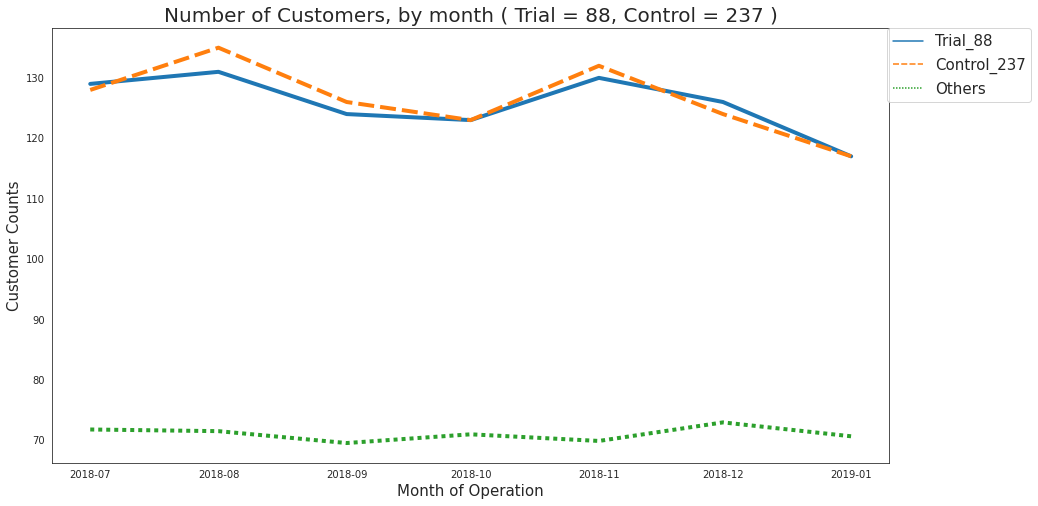

In [105]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["MONTH_ID","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 237]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,237,"others"])].reset_index()
paired_88_c["MONTH_ID"]= pd.to_datetime(paired_88_c["MONTH_ID"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["MONTH_ID"])
paired_88_c.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

# Assesment of the Trial:

Total Sales:

The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales. We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

Store 77

In [106]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingControlSales_77 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 77]["totSales"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 233]["totSales"].sum())
scalingControlSales_77 

1.023617303289553

In [107]:
# Apply the scaling factor
scaledControlSales_77 = measureOverTime[measureOverTime["STORE_NBR"]== 233]
scaledControlSales_77["controlSales"] = scaledControlSales_77["totSales"] * scalingControlSales_77
scaledControlSales_77

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,216.597421
2704,233,201812,279.8,47,1.063830,1.595745,3.730667,286.408121
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,181.692071
2706,233,201902,244.0,45,1.044444,1.555556,3.485714,249.762622
2707,233,201903,199.1,40,1.025000,1.475000,3.374576,203.802205
2708,233,201904,158.6,30,1.066667,1.533333,3.447826,162.345704


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [108]:
# Calculate the percentage difference between scaled control sales and trial sales
trialSales_77 = measureOverTime[measureOverTime["STORE_NBR"]== 77].reset_index(drop=True)
scaledControlSales_77 = scaledControlSales_77.reset_index(drop=True)
percentageDiff_77_s = pd.concat([trialSales_77["MONTH_ID"],trialSales_77["totSales"],scaledControlSales_77["controlSales"]],axis=1)
percentageDiff_77_s.columns=["MONTH_ID","trialSales","controlSales"]
percentageDiff_77_s["percentageDiff"]= (abs(percentageDiff_77_s["trialSales"]-percentageDiff_77_s["controlSales"]))/percentageDiff_77_s["controlSales"]
percentageDiff_77_s

,MONTH_ID,trialSales,controlSales,percentageDiff
0,201807,296.8,297.565550,0.002573
1,201808,255.5,292.652187,0.126950
2,201809,225.2,233.998916,0.037602
3,201810,204.5,190.085733,0.075830
4,201811,245.3,216.597421,0.132516
5,201812,267.3,286.408121,0.066716
6,201901,204.4,181.692071,0.124980
7,201902,235.0,249.762622,0.059107
8,201903,278.5,203.802205,0.366521
9,201904,263.5,162.345704,0.623080


We'd be looking into the percentage differences are significatnt!
let's take the standard deviation based on the scaled percentage difference in the pre-trial period

In [109]:
# Note that there are 8 months in the pre-trial period, hence 8 - 1 = 7 degrees of freedom
dof = 7

# standard deviation of percentage difference in pre-trail period
stdDev_77_s = percentageDiff_77_s[percentageDiff_77_s["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_77_s

0.04994076264142537

We will test with a null hypothesis of there being 0 difference between trial and control stores.

In [110]:
# Calculate the t-values for the trial months. 
percentageDiff_77_s["tValue"] = (percentageDiff_77_s["percentageDiff"]-0)/stdDev_77_s
percentageDiff_77_s

,MONTH_ID,trialSales,controlSales,percentageDiff,tValue
0,201807,296.8,297.565550,0.002573,0.051515
1,201808,255.5,292.652187,0.126950,2.542011
2,201809,225.2,233.998916,0.037602,0.752940
3,201810,204.5,190.085733,0.075830,1.518406
4,201811,245.3,216.597421,0.132516,2.653459
5,201812,267.3,286.408121,0.066716,1.335911
6,201901,204.4,181.692071,0.124980,2.502571
7,201902,235.0,249.762622,0.059107,1.183534
8,201903,278.5,203.802205,0.366521,7.339116
9,201904,263.5,162.345704,0.623080,12.476373


In [111]:
# Critical value under 95% confidence & degree of freedom = 7
from scipy.stats import t
t.ppf(0.975,dof) # two-tail

2.3646242510102993

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [112]:
# Create new variables Store_type, totSales and TransactionMonth in the data table 
# Create a new column "Store_Type"
measureOverTimeSales_77 = measureOverTime
pastSales_77 = measureOverTimeSales_77
trial_store = 77
control_store = 233
store_type = []
for i in pastSales_77["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastSales_77["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastSales_77["TransactionMonth"] = pd.to_datetime(pastSales_77["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastSales_77 = pastSales_77.loc[pastSales_77["Store_type"].isin(["Control","Trial"])]
pastSales_77 = pastSales_77.loc[:,["TransactionMonth", "Store_type","totSales"]]
pastSales_77

,TransactionMonth,Store_type,totSales
880,2018-07-01,Trial,296.8
881,2018-08-01,Trial,255.5
882,2018-09-01,Trial,225.2
883,2018-10-01,Trial,204.5
884,2018-11-01,Trial,245.3
885,2018-12-01,Trial,267.3
886,2019-01-01,Trial,204.4
887,2019-02-01,Trial,235.0
888,2019-03-01,Trial,278.5
889,2019-04-01,Trial,263.5


In [113]:
# Control store 95th percentile
pastSales_Controls95_77 = pastSales_77[pastSales_77["Store_type"] == "Control"]
pastSales_Controls95_77["totSales"] = pastSales_Controls95_77["totSales"] * (1+(stdDev_77_s*2))
pastSales_Controls95_77["Store_type"] = "Control 95th % confidence interval"
pastSales_Controls95_77 = pastSales_Controls95_77.loc[:,["TransactionMonth", "Store_type","totSales"]]
pastSales_Controls95_77.head()

,TransactionMonth,Store_type,totSales
2699,2018-07-01,Control 95th % confidence interval,319.735559
2700,2018-08-01,Control 95th % confidence interval,314.456128
2701,2018-09-01,Control 95th % confidence interval,251.432917
2702,2018-10-01,Control 95th % confidence interval,204.247999
2703,2018-11-01,Control 95th % confidence interval,232.734931


In [114]:
# Control store 5th percentile
pastSales_Controls5_77 = pastSales_77[pastSales_77["Store_type"] == "Control"]
pastSales_Controls5_77["totSales"] = pastSales_Controls95_77["totSales"] * (1-(stdDev_77_s*2))
pastSales_Controls5_77["Store_type"] = "Control 5th % confidence interval"
pastSales_Controls5_77 = pastSales_Controls5_77.loc[:,["TransactionMonth", "Store_type","totSales"]]
pastSales_Controls5_77.head()

,TransactionMonth,Store_type,totSales
2699,2018-07-01,Control 5th % confidence interval,287.799884
2700,2018-08-01,Control 5th % confidence interval,283.047770
2701,2018-09-01,Control 5th % confidence interval,226.319413
2702,2018-10-01,Control 5th % confidence interval,183.847398
2703,2018-11-01,Control 5th % confidence interval,209.489011


In [115]:
# Merge 3 tables above together
trialAssessment_77_s = pd.concat([pastSales_77, pastSales_Controls95_77, pastSales_Controls5_77])
trialAssessment_77_s

,TransactionMonth,Store_type,totSales
880,2018-07-01,Trial,296.800000
881,2018-08-01,Trial,255.500000
882,2018-09-01,Trial,225.200000
883,2018-10-01,Trial,204.500000
884,2018-11-01,Trial,245.300000
885,2018-12-01,Trial,267.300000
886,2019-01-01,Trial,204.400000
887,2019-02-01,Trial,235.000000
888,2019-03-01,Trial,278.500000
889,2019-04-01,Trial,263.500000


In [116]:
# Dataset for barplot
bar_77_s = trialAssessment_77_s
bar_77_s["TransactionMonth"] = bar_77_s["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_77_s = bar_77_s.set_index("TransactionMonth")
bar_77_s = bar_77_s.iloc[:24,:]
bar_77_s

,Store_type,totSales
TransactionMonth,,
2018-07,Trial,296.8
2018-08,Trial,255.5
2018-09,Trial,225.2
2018-10,Trial,204.5
2018-11,Trial,245.3
2018-12,Trial,267.3
2019-01,Trial,204.4
2019-02,Trial,235.0
2019-03,Trial,278.5


In [117]:
# Dataset for lineplot
line_77_s = trialAssessment_77_s.set_index(["TransactionMonth","Store_type"])["totSales"].unstack()
line_77_s = line_77_s.iloc[:,[1,2]]
line_77_s

Store_type,Control 5th % confidence interval,Control 95th % confidence interval
TransactionMonth,,
2018-07,287.799884,319.735559
2018-08,283.047770,314.456128
2018-09,226.319413,251.432917
2018-10,183.847398,204.247999
2018-11,209.489011,232.734931
2018-12,277.008626,307.746851
2019-01,175.729203,195.228971
2019-02,241.565778,268.371092
2019-03,197.113715,218.986412


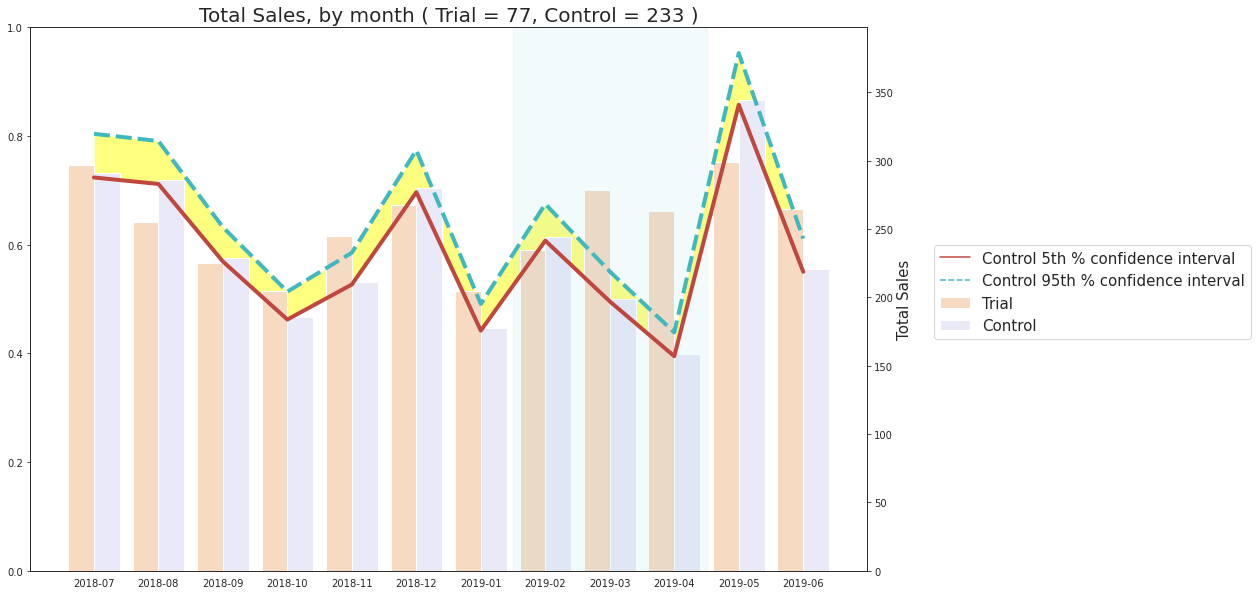

In [118]:
# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_77_s.index, y=bar_77_s["totSales"], hue=bar_77_s["Store_type"], data=bar_77_s,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_77_s, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence 
ax2.fill_between(line_77_s.index, 
                 line_77_s["Control 5th % confidence interval"], line_77_s["Control 95th % confidence interval"], 
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.1)
plt.title("Total Sales, by month ( Trial = 77, Control = 233 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside far from the 5% to 95% confidence interval of the control store in two of the three trial months.

Store 86:

In [119]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingControlSales_86 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 86]["totSales"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 155]["totSales"].sum())
#scalingControlSales_86

# Apply the scaling factor
scaledControlSales_86 = measureOverTime[measureOverTime["STORE_NBR"]== 155]
scaledControlSales_86["controlSales"] = scaledControlSales_86["totSales"] * scalingControlSales_86
#scaledControlSales_86

In [120]:
# Calculate the percentage difference between scaled control sales and trial sales
trialSales_86 = measureOverTime[measureOverTime["STORE_NBR"]== 86].reset_index(drop=True)
scaledControlSales_86 = scaledControlSales_86.reset_index(drop=True)
percentageDiff_86_s = pd.concat([trialSales_86["MONTH_ID"],trialSales_86["totSales"],scaledControlSales_86["controlSales"]],axis=1)
percentageDiff_86_s.columns=["MONTH_ID","trialSales","controlSales"]
percentageDiff_86_s["percentageDiff"]= (abs(percentageDiff_86_s["trialSales"]-percentageDiff_86_s["controlSales"]))/percentageDiff_86_s["controlSales"]
#percentageDiff_86_s

In [121]:
# Note that there are 8 months in the pre-trial period, hence 8 - 1 = 7 degrees of freedom
dof = 7

# standard deviation of percentage difference in pre-trail period
stdDev_86_s = percentageDiff_86_s[percentageDiff_86_s["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_86_s

0.025833952854772368

In [122]:
# Calculate the t-values for the trial months. 
percentageDiff_86_s["tValue"] = (percentageDiff_86_s["percentageDiff"]-0)/stdDev_86_s
percentageDiff_86_s

,MONTH_ID,trialSales,controlSales,percentageDiff,tValue
0,201807,892.20,896.922236,0.005265,0.203799
1,201808,764.05,759.269991,0.006296,0.243692
2,201809,914.60,984.034086,0.070561,2.731315
3,201810,948.40,934.948790,0.014387,0.556907
4,201811,918.00,871.894555,0.052880,2.046904
5,201812,841.20,824.361363,0.020426,0.790676
6,201901,841.40,848.418979,0.008273,0.320238
7,201902,913.20,864.522060,0.056306,2.179542
8,201903,1026.80,780.320405,0.315870,12.226922
9,201904,848.20,819.317024,0.035253,1.364580


In [123]:
# Create new variables Store_type, totSales and TransactionMonth in the data table 
# Create a new column "Store_Type"
measureOverTimeSales_86 = measureOverTime
pastSales_86 = measureOverTimeSales_86
trial_store = 86
control_store = 155
store_type = []
for i in pastSales_86["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastSales_86["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastSales_86["TransactionMonth"] = pd.to_datetime(pastSales_86["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastSales_86 = pastSales_86.loc[pastSales_86["Store_type"].isin(["Control","Trial"])]
pastSales_86 = pastSales_86.loc[:,["TransactionMonth", "Store_type","totSales"]]
#pastSales_86

In [124]:
# Control store 95th percentile
pastSales_Controls95_86 = pastSales_86[pastSales_86["Store_type"] == "Control"]
pastSales_Controls95_86["totSales"] = pastSales_Controls95_86["totSales"] * (1+(stdDev_86_s*2))
pastSales_Controls95_86["Store_type"] = "Control 95th % confidence interval"
pastSales_Controls95_86 = pastSales_Controls95_86.loc[:,["TransactionMonth", "Store_type","totSales"]]
#pastSales_Controls95_86.head()

In [125]:
# Control store 5th percentile
pastSales_Controls5_86 = pastSales_86[pastSales_86["Store_type"] == "Control"]
pastSales_Controls5_86["totSales"] = pastSales_Controls95_86["totSales"] * (1-(stdDev_86_s*2))
pastSales_Controls5_86["Store_type"] = "Control 5th % confidence interval"
pastSales_Controls5_86 = pastSales_Controls5_86.loc[:,["TransactionMonth", "Store_type","totSales"]]
#pastSales_Controls5_86.head()

In [126]:
# Merge 3 tables above together
trialAssessment_86_s = pd.concat([pastSales_86, pastSales_Controls95_86, pastSales_Controls5_86])
#trialAssessment_86_s

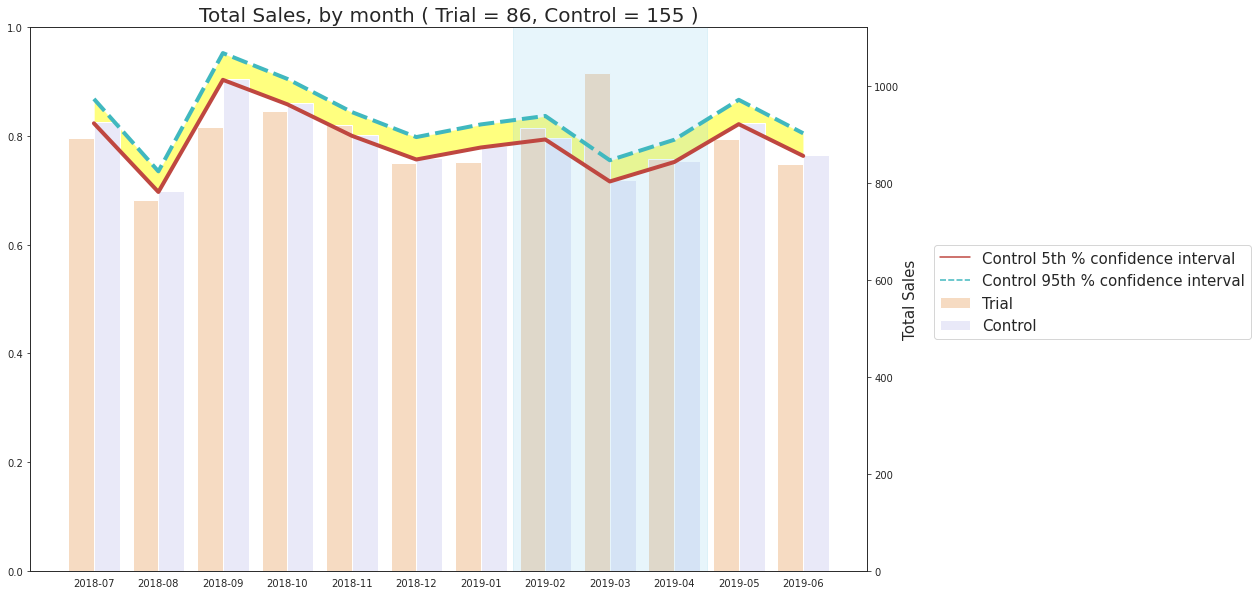

In [127]:
# Plotting these in one nice graph
# Dataset for barplot
bar_86_s = trialAssessment_86_s
bar_86_s["TransactionMonth"] = bar_86_s["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_86_s = bar_86_s.set_index("TransactionMonth")
bar_86_s = bar_86_s.iloc[:24,:]
#bar_86_s

# Dataset for lineplot
line_86_s = trialAssessment_86_s.set_index(["TransactionMonth","Store_type"])["totSales"].unstack()
line_86_s = line_86_s.iloc[:,[1,2]]
line_86_s

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_86_s.index, y=bar_86_s["totSales"], hue=bar_86_s["Store_type"], data=bar_86_s,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_86_s, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence 
ax2.fill_between(line_86_s.index, 
                 line_86_s["Control 5th % confidence interval"], line_86_s["Control 95th % confidence interval"], 
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.2)
plt.title("Total Sales, by month ( Trial = 86, Control = 155 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.

Store 88:

In [128]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingControlSales_88 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 88]["totSales"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 237]["totSales"].sum())
#scalingControlSales_88

In [129]:
# Apply the scaling factor
scaledControlSales_88 = measureOverTime[measureOverTime["STORE_NBR"]== 237]
scaledControlSales_88["controlSales"] = scaledControlSales_88["totSales"] * scalingControlSales_88
#scaledControlSales_88

In [130]:
# Calculate the percentage difference between scaled control sales and trial sales
trialSales_88 = measureOverTime[measureOverTime["STORE_NBR"]== 88].reset_index(drop=True)
scaledControlSales_88 = scaledControlSales_88.reset_index(drop=True)
percentageDiff_88_s = pd.concat([trialSales_88["MONTH_ID"],trialSales_88["totSales"],scaledControlSales_88["controlSales"]],axis=1)
percentageDiff_88_s.columns=["MONTH_ID","trialSales","controlSales"]
percentageDiff_88_s["percentageDiff"]= (abs(percentageDiff_88_s["trialSales"]-percentageDiff_88_s["controlSales"]))/percentageDiff_88_s["controlSales"]
#percentageDiff_88_s

In [131]:
# Note that there are 8 months in the pre-trial period, hence 8 - 1 = 7 degrees of freedom
dof = 7

# standard deviation of percentage difference in pre-trail period
stdDev_88_s = percentageDiff_88_s[percentageDiff_88_s["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_88_s

0.0334678673030788

In [132]:
# Calculate the t-values for the trial months. 
percentageDiff_88_s["tValue"] = (percentageDiff_88_s["percentageDiff"]-0)/stdDev_88_s
percentageDiff_88_s

,MONTH_ID,trialSales,controlSales,percentageDiff,tValue
0,201807,1310.00,1450.657086,0.096961,2.897136
1,201808,1323.80,1369.931485,0.033674,1.006168
2,201809,1423.00,1324.260425,0.074562,2.227870
3,201810,1352.40,1350.401097,0.001480,0.044228
4,201811,1382.80,1399.777923,0.012129,0.362408
5,201812,1325.20,1266.971288,0.045959,1.373227
6,201901,1266.40,1221.600696,0.036673,1.095756
7,201902,1370.20,1406.989143,0.026147,0.781270
8,201903,1477.20,1210.082775,0.220743,6.595668
9,201904,1439.40,1206.477165,0.193060,5.768527


In [133]:
# Create new variables Store_type, totSales and TransactionMonth in the data table 
# Create a new column "Store_Type"
measureOverTimeSales_88 = measureOverTime
pastSales_88 = measureOverTimeSales_88
trial_store = 88
control_store = 237
store_type = []
for i in pastSales_88["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastSales_88["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastSales_88["TransactionMonth"] = pd.to_datetime(pastSales_88["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastSales_88 = pastSales_88.loc[pastSales_88["Store_type"].isin(["Control","Trial"])]
pastSales_88 = pastSales_88.loc[:,["TransactionMonth", "Store_type","totSales"]]
#pastSales_88

In [134]:
# Control store 95th percentile
pastSales_Controls95_88 = pastSales_88[pastSales_88["Store_type"] == "Control"]
pastSales_Controls95_88["totSales"] = pastSales_Controls95_88["totSales"] * (1+(stdDev_88_s*2))
pastSales_Controls95_88["Store_type"] = "Control 95th % confidence interval"
pastSales_Controls95_88 = pastSales_Controls95_88.loc[:,["TransactionMonth", "Store_type","totSales"]]
#pastSales_Controls95_88.head()

In [135]:
# Control store 5th percentile
pastSales_Controls5_88 = pastSales_88[pastSales_88["Store_type"] == "Control"]
pastSales_Controls5_88["totSales"] = pastSales_Controls95_88["totSales"] * (1-(stdDev_88_s*2))
pastSales_Controls5_88["Store_type"] = "Control 5th % confidence interval"
pastSales_Controls5_88 = pastSales_Controls5_88.loc[:,["TransactionMonth", "Store_type","totSales"]]
#pastSales_Controls5_88.head()

In [136]:
# Merge 3 tables above together
trialAssessment_88_s = pd.concat([pastSales_88, pastSales_Controls95_88, pastSales_Controls5_88])
#trialAssessment_88_s


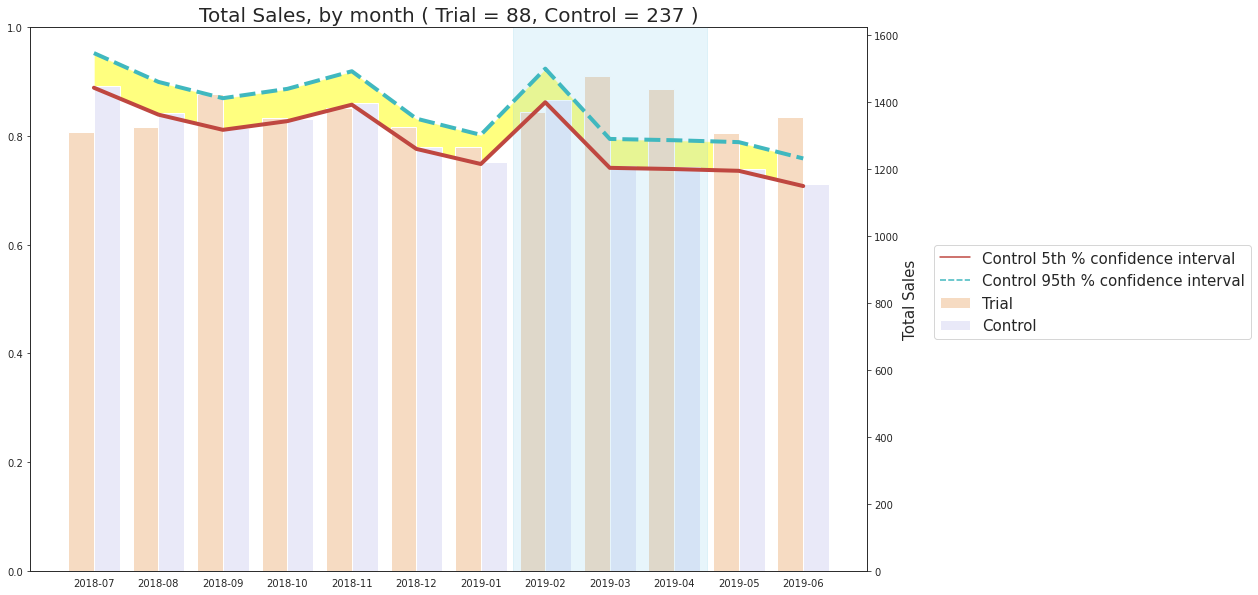

In [137]:
# Plotting these in one nice graph
# Dataset for barplot
bar_88_s = trialAssessment_88_s
bar_88_s["TransactionMonth"] = bar_88_s["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_88_s = bar_88_s.set_index("TransactionMonth")
bar_88_s = bar_88_s.iloc[:24,:]
#bar_88_s

# Dataset for lineplot
line_88_s = trialAssessment_88_s.set_index(["TransactionMonth","Store_type"])["totSales"].unstack()
line_88_s = line_88_s.iloc[:,[1,2]]
line_88_s

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_88_s.index, y=bar_88_s["totSales"], hue=bar_88_s["Store_type"], data=bar_88_s,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_88_s, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence 
ax2.fill_between(line_88_s.index, 
                 line_88_s["Control 5th % confidence interval"], line_88_s["Control 95th % confidence interval"], 
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.2)
plt.title("Total Sales, by month ( Trial = 88, Control = 237 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total Sales", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

Number of Customers:

Store 77:

In [138]:
# This would be a repeat of the steps before for number of customers
# Scale pre-trial control customer counts to match pre-trial trial store customer counts
scalingControlCust_77 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 77]["nCustomers"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 233]["nCustomers"].sum())
scalingControlCust_77 


1.0033557046979866

In [139]:
# Apply the scaling factor
scaledControlCust_77 = measureOverTime[measureOverTime["STORE_NBR"]== 233]
scaledControlCust_77["controlCust"] = scaledControlCust_77["nCustomers"] * scalingControlCust_77
scaledControlCust_77

,STORE_NBR,MONTH_ID,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,Store_type,TransactionMonth,controlCust
2699,233,201807,290.7,51,1.058824,1.725490,3.303409,Other Stores,2018-07-01,51.171141
2700,233,201808,285.9,48,1.041667,1.666667,3.573750,Other Stores,2018-08-01,48.161074
2701,233,201809,228.6,42,1.071429,1.666667,3.265714,Other Stores,2018-09-01,42.140940
2702,233,201810,185.7,35,1.028571,1.600000,3.316071,Other Stores,2018-10-01,35.117450
2703,233,201811,211.6,40,1.025000,1.550000,3.412903,Other Stores,2018-11-01,40.134228
2704,233,201812,279.8,47,1.063830,1.595745,3.730667,Other Stores,2018-12-01,47.157718
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,Other Stores,2019-01-01,35.117450
2706,233,201902,244.0,45,1.044444,1.555556,3.485714,Other Stores,2019-02-01,45.151007
2707,233,201903,199.1,40,1.025000,1.475000,3.374576,Other Stores,2019-03-01,40.134228
2708,233,201904,158.6,30,1.066667,1.533333,3.447826,Other Stores,2019-04-01,30.100671


In [140]:
# Calculate the percentage difference between scaled control customer counts and trial customer counts
trialCust_77 = measureOverTime[measureOverTime["STORE_NBR"]== 77].reset_index(drop=True)
scaledControlCust_77 = scaledControlCust_77.reset_index(drop=True)
percentageDiff_77_c = pd.concat([trialCust_77["MONTH_ID"],trialCust_77["nCustomers"],scaledControlCust_77["controlCust"]],axis=1)
percentageDiff_77_c.columns=["MONTH_ID","trialCust","controlCust"]
percentageDiff_77_c["percentageDiff"]= (abs(percentageDiff_77_c["trialCust"]-percentageDiff_77_c["controlCust"]))/percentageDiff_77_c["controlCust"]
percentageDiff_77_c

,MONTH_ID,trialCust,controlCust,percentageDiff
0,201807,51,51.171141,0.003344
1,201808,47,48.161074,0.024108
2,201809,42,42.140940,0.003344
3,201810,37,35.117450,0.053607
4,201811,41,40.134228,0.021572
5,201812,46,47.157718,0.024550
6,201901,35,35.117450,0.003344
7,201902,45,45.151007,0.003344
8,201903,50,40.134228,0.245819
9,201904,47,30.100671,0.561427


In [141]:
# standard deviation of percentage difference in pre-trail period
stdDev_77_c = percentageDiff_77_c[percentageDiff_77_c["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_77_c

0.01824074855824395

In [142]:
# Calculate the t-values for the trial months. 
percentageDiff_77_c["tValue"] = (percentageDiff_77_c["percentageDiff"]-0)/stdDev_77_c
percentageDiff_77_c

,MONTH_ID,trialCust,controlCust,percentageDiff,tValue
0,201807,51,51.171141,0.003344,0.183352
1,201808,47,48.161074,0.024108,1.321664
2,201809,42,42.140940,0.003344,0.183352
3,201810,37,35.117450,0.053607,2.938874
4,201811,41,40.134228,0.021572,1.182622
5,201812,46,47.157718,0.024550,1.345883
6,201901,35,35.117450,0.003344,0.183352
7,201902,45,45.151007,0.003344,0.183352
8,201903,50,40.134228,0.245819,13.476388
9,201904,47,30.100671,0.561427,30.778725


In [143]:
# Create new variables Store_type, nCustomers and TransactionMonth in the data table 
# Create a new column "Store_Type"
measureOverTimeCust_77 = measureOverTime
pastCust_77 = measureOverTimeCust_77
trial_store = 77
control_store = 233
store_type = []
for i in pastCust_77["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastCust_77["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastCust_77["TransactionMonth"] = pd.to_datetime(pastCust_77["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastCust_77 = pastCust_77.loc[pastCust_77["Store_type"].isin(["Control","Trial"])]
pastCust_77 = pastCust_77.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
pastCust_77

,TransactionMonth,Store_type,nCustomers
880,2018-07-01,Trial,51
881,2018-08-01,Trial,47
882,2018-09-01,Trial,42
883,2018-10-01,Trial,37
884,2018-11-01,Trial,41
885,2018-12-01,Trial,46
886,2019-01-01,Trial,35
887,2019-02-01,Trial,45
888,2019-03-01,Trial,50
889,2019-04-01,Trial,47


In [144]:
# Control store 95th percentile
pastCust_Controls95_77 = pastCust_77[pastCust_77["Store_type"] == "Control"]
pastCust_Controls95_77["nCustomers"] = pastCust_Controls95_77["nCustomers"] * (1+(stdDev_77_c*2))
pastCust_Controls95_77["Store_type"] = "Control 95th % confidence interval"
pastCust_Controls95_77 = pastCust_Controls95_77.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
pastCust_Controls95_77.head()

,TransactionMonth,Store_type,nCustomers
2699,2018-07-01,Control 95th % confidence interval,52.860556
2700,2018-08-01,Control 95th % confidence interval,49.751112
2701,2018-09-01,Control 95th % confidence interval,43.532223
2702,2018-10-01,Control 95th % confidence interval,36.276852
2703,2018-11-01,Control 95th % confidence interval,41.459260


In [145]:
# Control store 5th percentile
pastCust_Controls5_77 = pastCust_77[pastCust_77["Store_type"] == "Control"]
pastCust_Controls5_77["nCustomers"] = pastCust_Controls95_77["nCustomers"] * (1-(stdDev_77_c*2))
pastCust_Controls5_77["Store_type"] = "Control 5th % confidence interval"
pastCust_Controls5_77 = pastCust_Controls5_77.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
pastCust_Controls5_77.head()

,TransactionMonth,Store_type,nCustomers
2699,2018-07-01,Control 5th % confidence interval,50.932124
2700,2018-08-01,Control 5th % confidence interval,47.936117
2701,2018-09-01,Control 5th % confidence interval,41.944102
2702,2018-10-01,Control 5th % confidence interval,34.953419
2703,2018-11-01,Control 5th % confidence interval,39.946764


In [146]:
# Merge 3 tables above together
trialAssessment_77_c = pd.concat([pastCust_77, pastCust_Controls95_77, pastCust_Controls5_77])
trialAssessment_77_c

,TransactionMonth,Store_type,nCustomers
880,2018-07-01,Trial,51.000000
881,2018-08-01,Trial,47.000000
882,2018-09-01,Trial,42.000000
883,2018-10-01,Trial,37.000000
884,2018-11-01,Trial,41.000000
885,2018-12-01,Trial,46.000000
886,2019-01-01,Trial,35.000000
887,2019-02-01,Trial,45.000000
888,2019-03-01,Trial,50.000000
889,2019-04-01,Trial,47.000000


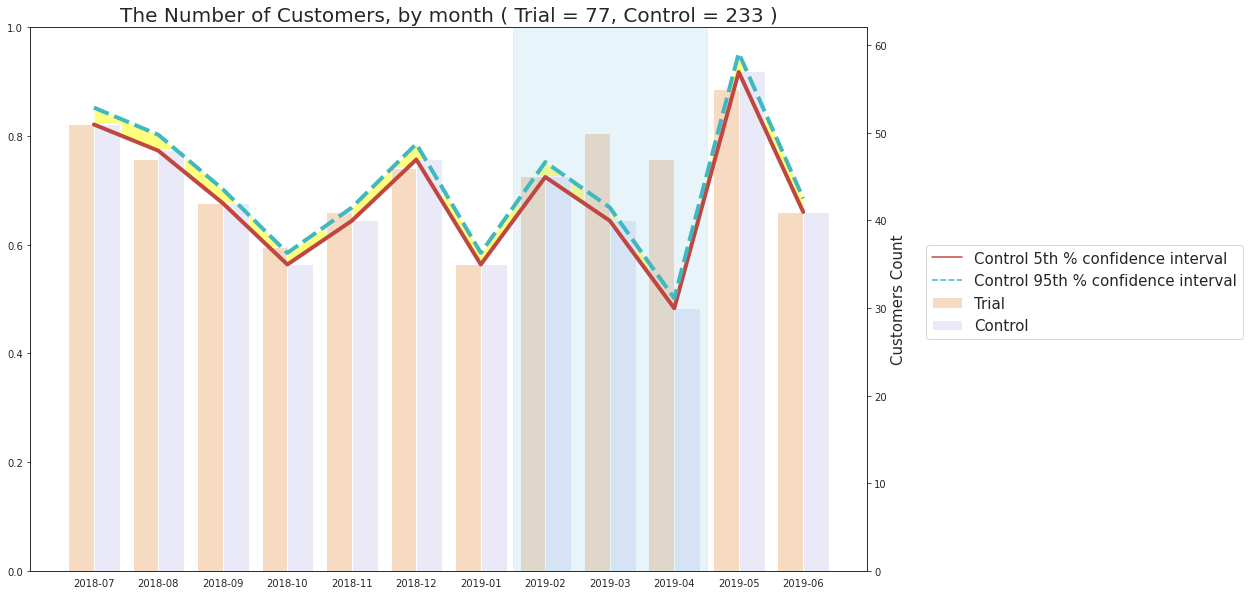

In [147]:
# Dataset for barplot
bar_77_c = trialAssessment_77_c
bar_77_c["TransactionMonth"] = bar_77_c["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_77_c = bar_77_c.set_index("TransactionMonth")
bar_77_c = bar_77_c.iloc[:24,:]
#bar_77_c

# Dataset for lineplot
line_77_c = trialAssessment_77_c.set_index(["TransactionMonth","Store_type"])["nCustomers"].unstack()
line_77_c = line_77_c.iloc[:,[1,2]]
line_77_c

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_77_c.index, y=bar_77_c["nCustomers"], hue=bar_77_c["Store_type"], data=bar_77_c,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_77_c, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence 
ax2.fill_between(line_77_c.index, 
                 line_77_c["Control 5th % confidence interval"], line_77_c["Control 95th % confidence interval"], 
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.2)
plt.title("The Number of Customers, by month ( Trial = 77, Control = 233 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customers Count", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.07,0.6),borderaxespad = 0.)

Store 86

In [148]:
# This would be a repeat of the steps before for number of customers
# Scale pre-trial control customer counts to match pre-trial trial store customer counts
scalingControlCust_86 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 86]["nCustomers"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 155]["nCustomers"].sum())
#scalingControlCust_86

# Apply the scaling factor
scaledControlCust_86 = measureOverTime[measureOverTime["STORE_NBR"]== 155]
scaledControlCust_86["controlCust"] = scaledControlCust_86["nCustomers"] * scalingControlCust_86
#scaledControlCust_86

In [149]:
# Calculate the percentage difference between scaled control customer counts and trial customer counts
trialCust_86 = measureOverTime[measureOverTime["STORE_NBR"]== 86].reset_index(drop=True)
scaledControlCust_86 = scaledControlCust_86.reset_index(drop=True)
percentageDiff_86_c = pd.concat([trialCust_86["MONTH_ID"],trialCust_86["nCustomers"],scaledControlCust_86["controlCust"]],axis=1)
percentageDiff_86_c.columns=["MONTH_ID","trialCust","controlCust"]
percentageDiff_86_c["percentageDiff"]= (abs(percentageDiff_86_c["trialCust"]-percentageDiff_86_c["controlCust"]))/percentageDiff_86_c["controlCust"]
#percentageDiff_86_c

In [150]:
# standard deviation of percentage difference in pre-trail period
stdDev_86_c = percentageDiff_86_c[percentageDiff_86_c["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_86_c

0.010687444701395238

In [151]:
# Calculate the t-values for the trial months. 
percentageDiff_86_c["tValue"] = (percentageDiff_86_c["percentageDiff"]-0)/stdDev_86_c
percentageDiff_86_c

,MONTH_ID,trialCust,controlCust,percentageDiff,tValue
0,201807,99,101.0,0.019802,1.852826
1,201808,94,91.0,0.032967,3.084651
2,201809,103,103.0,0.000000,0.000000
3,201810,109,108.0,0.009259,0.866368
4,201811,100,101.0,0.009901,0.926413
5,201812,98,97.0,0.010309,0.964616
6,201901,94,96.0,0.020833,1.949328
7,201902,107,95.0,0.126316,11.819082
8,201903,115,94.0,0.223404,20.903430
9,201904,105,99.0,0.060606,5.670772


In [152]:
# Create new variables Store_type, nCustomers and TransactionMonth in the data table 
# Create a new column "Store_Type"
measureOverTimeCust_86 = measureOverTime
pastCust_86 = measureOverTimeCust_86
trial_store = 86
control_store = 155
store_type = []
for i in pastCust_86["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastCust_86["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastCust_86["TransactionMonth"] = pd.to_datetime(pastCust_86["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastCust_86 = pastCust_86.loc[pastCust_86["Store_type"].isin(["Control","Trial"])]
pastCust_86 = pastCust_86.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
#pastCust_86

In [153]:
# Control store 95th percentile
pastCust_Controls95_86 = pastCust_86[pastCust_86["Store_type"] == "Control"]
pastCust_Controls95_86["nCustomers"] = pastCust_Controls95_86["nCustomers"] * (1+(stdDev_86_c*2))
pastCust_Controls95_86["Store_type"] = "Control 95th % confidence interval"
pastCust_Controls95_86 = pastCust_Controls95_86.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
#pastCust_Controls95_86.head()

# Control store 5th percentile
pastCust_Controls5_86 = pastCust_86[pastCust_86["Store_type"] == "Control"]
pastCust_Controls5_86["nCustomers"] = pastCust_Controls95_86["nCustomers"] * (1-(stdDev_86_c*2))
pastCust_Controls5_86["Store_type"] = "Control 5th % confidence interval"
pastCust_Controls5_86 = pastCust_Controls5_86.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
#pastCust_Controls5_86.head()

In [154]:
# Merge 3 tables above together
trialAssessment_86_c = pd.concat([pastCust_86, pastCust_Controls95_86, pastCust_Controls5_86])
#trialAssessment_86_c

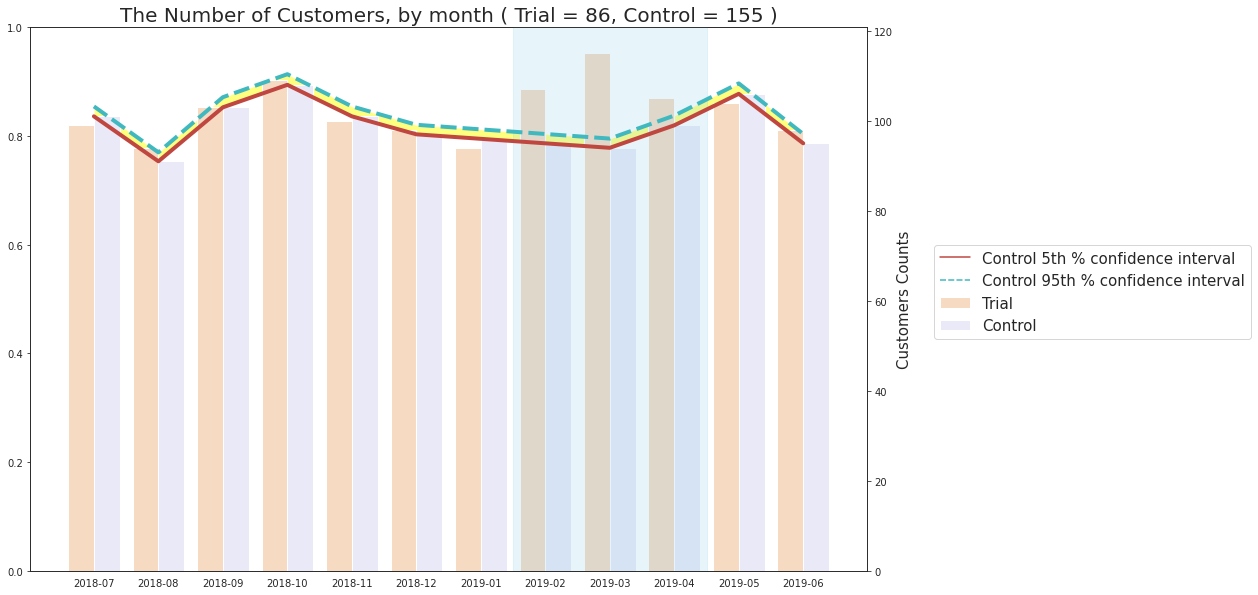

In [155]:
# Dataset for barplot
bar_86_c = trialAssessment_86_c
bar_86_c["TransactionMonth"] = bar_86_c["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_86_c = bar_86_c.set_index("TransactionMonth")
bar_86_c = bar_86_c.iloc[:24,:]
#bar_86_c

# Dataset for lineplot
line_86_c = trialAssessment_86_c.set_index(["TransactionMonth","Store_type"])["nCustomers"].unstack()
line_86_c = line_86_c.iloc[:,[1,2]]
line_86_c

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_86_c.index, y=bar_86_c["nCustomers"], hue=bar_86_c["Store_type"], data=bar_86_c,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_86_c, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence 
ax2.fill_between(line_86_c.index, 
                 line_86_c["Control 5th % confidence interval"], line_86_c["Control 95th % confidence interval"], 
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
plt.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.2)
plt.title("The Number of Customers, by month ( Trial = 86, Control = 155 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customers Counts", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)

Store 88

In [156]:
# This would be a repeat of the steps before for number of customers
# Scale pre-trial control customer counts to match pre-trial trial store customer counts
scalingControlCust_88 = (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 88]["nCustomers"].sum()) / (preTrialMeasures[preTrialMeasures["STORE_NBR"] == 237]["nCustomers"].sum())
#scalingControlCust_88

# Apply the scaling factor
scaledControlCust_88 = measureOverTime[measureOverTime["STORE_NBR"]== 237]
scaledControlCust_88["controlCust"] = scaledControlCust_88["nCustomers"] * scalingControlCust_88
#scaledControlCust_88

In [157]:
# Calculate the percentage difference between scaled control customer counts and trial customer counts
trialCust_88 = measureOverTime[measureOverTime["STORE_NBR"]== 88].reset_index(drop=True)
scaledControlCust_88 = scaledControlCust_88.reset_index(drop=True)
percentageDiff_88_c = pd.concat([trialCust_88["MONTH_ID"],trialCust_88["nCustomers"],scaledControlCust_88["controlCust"]],axis=1)
percentageDiff_88_c.columns=["MONTH_ID","trialCust","controlCust"]
percentageDiff_88_c["percentageDiff"]= (abs(percentageDiff_88_c["trialCust"]-percentageDiff_88_c["controlCust"]))/percentageDiff_88_c["controlCust"]
#percentageDiff_88_c

In [158]:
# standard deviation of percentage difference in pre-trail period
stdDev_88_c = percentageDiff_88_c[percentageDiff_88_c["MONTH_ID"]<201902]["percentageDiff"].std()
stdDev_88_c

0.00741024435207507

In [159]:
# Calculate the t-values for the trial months. 
percentageDiff_88_c["tValue"] = (percentageDiff_88_c["percentageDiff"]-0)/stdDev_88_c
percentageDiff_88_c

,MONTH_ID,trialCust,controlCust,percentageDiff,tValue
0,201807,129,127.276836,0.013539,1.827026
1,201808,131,134.237288,0.024116,3.254435
2,201809,124,125.288136,0.010281,1.387456
3,201810,123,122.305085,0.005682,0.766752
4,201811,130,131.254237,0.009556,1.289537
5,201812,126,123.299435,0.021902,2.955705
6,201901,117,116.338983,0.005682,0.766752
7,201902,124,125.288136,0.010281,1.387456
8,201903,134,118.327684,0.132448,17.873693
9,201904,128,119.322034,0.072727,9.814423


In [160]:
# Create new variables Store_type, nCustomers and TransactionMonth in the data table 
# Create a new column "Store_Type"
measureOverTimeCust_88 = measureOverTime
pastCust_88 = measureOverTimeCust_88
trial_store = 88
control_store = 237
store_type = []
for i in pastCust_88["STORE_NBR"]:
    if i == trial_store:
        store_type.append("Trial")
    elif i == control_store:
        store_type.append("Control")
    else:
        store_type.append("Other Stores")
pastCust_88["Store_type"] = store_type

# Create a new column 'TransactionMonth'
pastCust_88["TransactionMonth"] = pd.to_datetime(pastCust_88["MONTH_ID"], format = "%Y%m")

# select Trial and control store
pastCust_88 = pastCust_88.loc[pastCust_88["Store_type"].isin(["Control","Trial"])]
pastCust_88 = pastCust_88.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
#pastCust_88

In [161]:
# Control store 95th percentile
pastCust_Controls95_88 = pastCust_88[pastCust_88["Store_type"] == "Control"]
pastCust_Controls95_88["nCustomers"] = pastCust_Controls95_88["nCustomers"] * (1+(stdDev_88_c*2))
pastCust_Controls95_88["Store_type"] = "Control 95th % confidence interval"
pastCust_Controls95_88 = pastCust_Controls95_88.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
#pastCust_Controls95_88.head()

# Control store 5th percentile
pastCust_Controls5_88 = pastCust_88[pastCust_88["Store_type"] == "Control"]
pastCust_Controls5_88["nCustomers"] = pastCust_Controls95_88["nCustomers"] * (1-(stdDev_88_c*2))
pastCust_Controls5_88["Store_type"] = "Control 5th % confidence interval"
pastCust_Controls5_88 = pastCust_Controls5_88.loc[:,["TransactionMonth", "Store_type","nCustomers"]]
#pastCust_Controls5_88.head()

In [162]:
# Merge 3 tables above together
trialAssessment_88_c = pd.concat([pastCust_88, pastCust_Controls95_88, pastCust_Controls5_88])
#trialAssessment_88_c

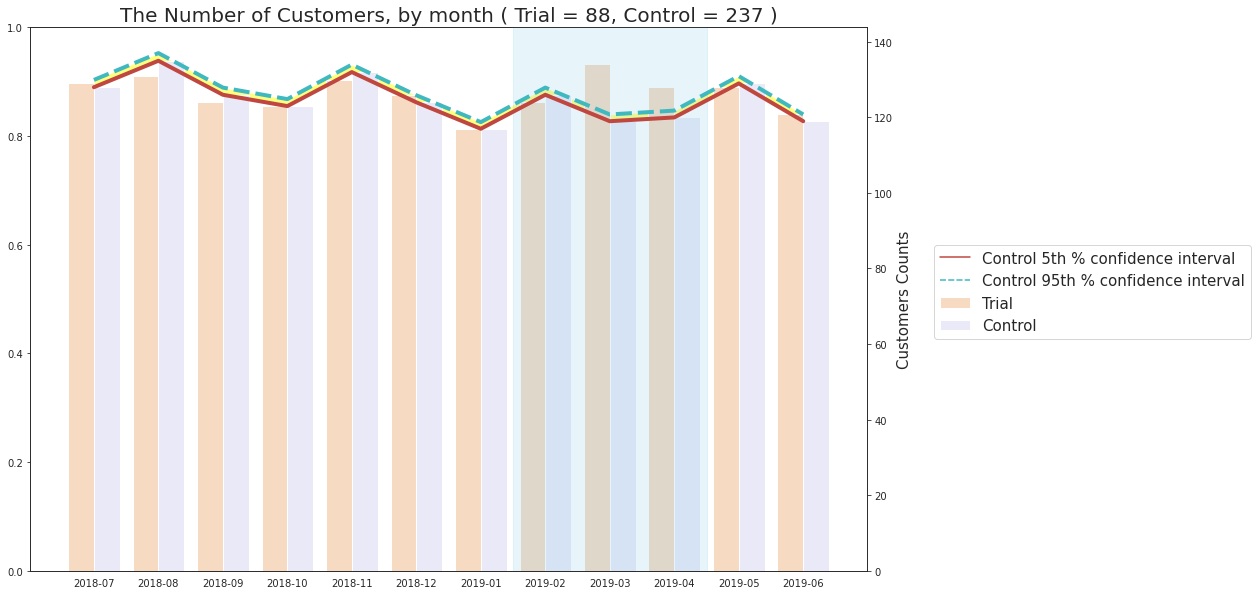

In [163]:
# Dataset for barplot
bar_88_c = trialAssessment_88_c
bar_88_c["TransactionMonth"] = bar_88_c["TransactionMonth"].dt.strftime("%Y-%m").astype("str")
bar_88_c = bar_88_c.set_index("TransactionMonth")
bar_88_c = bar_88_c.iloc[:24,:]
#bar_88_c

# Dataset for lineplot
line_88_c = trialAssessment_88_c.set_index(["TransactionMonth","Store_type"])["nCustomers"].unstack()
line_88_c = line_88_c.iloc[:,[1,2]]
line_88_c

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
ax2 = ax1.twinx()
ax1 = sns.barplot(x=bar_88_c.index, y=bar_88_c["nCustomers"], hue=bar_88_c["Store_type"], data=bar_88_c,
                 palette=["peachpuff","lavender"])
ax2 = sns.lineplot(data=line_88_c, linewidth=4, palette=sns.hls_palette(2, l=.5, s=.5))
# Yellow shadow to show values between 5% and 95% confidence 
ax2.fill_between(line_88_c.index, 
                 line_88_c["Control 5th % confidence interval"], line_88_c["Control 95th % confidence interval"], 
                 facecolor="yellow", alpha=0.5)
# blue shadow to show trial period
ax1.axvspan(xmin=6.5, xmax=9.5, color = 'skyblue', alpha = 0.2)
plt.title("The Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customers Counts", fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.08,0.6),borderaxespad = 0.)